# Space filling curves
This notebook provides the code to replicate the images of the study.

## Setup

Load all packages:

In [1]:
from preprocessing import representation, preprocess, helpers,loadData
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.io import loadmat
import seaborn as sns
import os
import pandas as pd
import itertools
from tqdm import tqdm
from nltk.tokenize import RegexpTokenizer
sns.set_theme("paper","ticks",font="serif",font_scale=2)
batch_size = 256
PATH_FIG="figure"
os.makedirs(PATH_FIG,exist_ok=True)

# Palette well adapted for black and white printing
colors = ["#000000", "#238B45", "#FD8D3C", "#D4B9DA", "#FFEDA0"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

## Data preparation

Words between 4000 and 8000 occurrences
 ['ABOUT', 'AFTER', 'BEFORE', 'CAME', 'COME', 'COULD', 'DOWN', 'GOOD', 'GREAT', 'INTO', 'KNOW', 'LIKE', 'LITTLE', 'MADE', 'MORE', 'MUCH', 'MUST', 'NEVER', 'ONLY', 'OTHER', 'OVER', 'SHOULD', 'SOME', 'SUCH', 'THAN', 'THESE', 'TIME', 'UPON', 'VERY', 'WELL', 'YOUR']


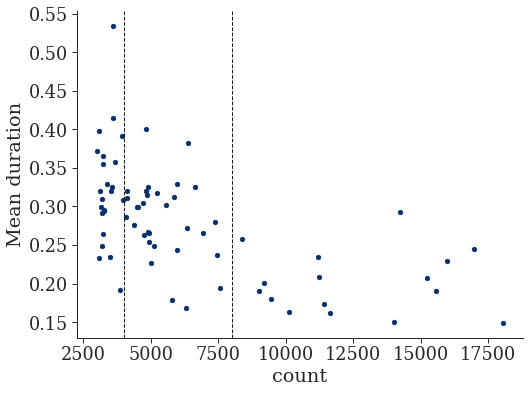

In [3]:
def select_words(save=False,figsize=(8,6)):
    path_libri="data/LibriSpeech"
    name_file="train-clean-360"
    df=pd.read_csv(os.path.join(path_libri, 'word_labels',name_file+ '-selected-' + str(1000) + '.txt'),
                        sep=" ", header=None,usecols=[0,1,2,3,4],names=["file","unknown","start","length","class"])
    stats=df.groupby("class").length.agg(['mean', 'count','std'])
    mask=(stats["count"]>3000)&(stats["count"]<20000)
    print("Words between 4000 and 8000 occurrences\n",stats[(stats["count"]>4000) &(stats["count"]<8000)].index.tolist())
    filter_df=stats[mask].copy()
    fig,ax=plt.subplots(1,1,figsize=figsize)
    filter_df.plot(x="count",y="mean",kind="scatter",ylabel="Mean duration",ax=ax,color=next(itertools.cycle(sns.color_palette())))
    plt.axvline(4000, 0, 1, linewidth=1,color='k', linestyle='--')
    plt.axvline(8000, 0, 1, linewidth=1,color='k', linestyle='--')
    sns.despine(fig)
    if save:
        plt.savefig(os.path.join(PATH_FIG,"selected_words.png"),dpi=150)
    
select_words(save=True)

We remove some words that are not appearing in the transcript.

In [5]:
split = "dev-clean"
def find_line(string, fp, previous_pos):
    # set at the previous position (the data is already ordered)
    fp.seek(previous_pos)
    for i, line in enumerate(fp):
        if string in line:
            return line, i
    raise ValueError("not found")

def clean_data_libri(split,words):
    assert split in ["train","val","test"]
    path = "data/LibriSpeech"
    filenames={"train":"train-clean-360","val":"dev-clean","test":"test-clean"}
    filename=filenames[split]
    # load meta data
    data = pd.read_csv(os.path.join(path, 'word_labels', filename + '-selected-' + str(1000) + '.txt'), sep=" ",
                    header=None, usecols=[0, 1, 2, 3, 4], names=["file", "unknown", "start", "length", "class"])
    # group by folder (each .txt file contains the transcript of the folder)
    data["folders"] = data.file.apply(lambda x: "-".join(x.split("-")[:-1]))
    groups = data.groupby("folders")

    list_of_results = []
    for name, group in tqdm(groups):
        # find transcript
        path_transcipt = os.path.join(path, "split", filename, *name.split("-"), name+".trans.txt")
        previous_pos = 0
        with open(path_transcipt, "r") as f:
            for _, row in group.iterrows():
                # transcripted lines are appearing in the same order than data, so we keep the previous position in memory
                line, previous_pos = find_line(row.file, f, previous_pos)
                # containWord determines if the word (=the class name) is appearing in the transcript of the sentence
                list_of_results.append({"indextrans": previous_pos, "filename": row.file, "word": row["class"].upper(
                ), "containWord": row["class"].upper() in RegexpTokenizer(r'\w+').tokenize(line)})

    results=pd.DataFrame(list_of_results)
    # count how many words are not appearing in the transcript per classes
    count_mismatch=results[~results.containWord].groupby("word").filename.apply(len)

    # select only words appearing in words
    print("Number of words that are not appearing in the transcipt (per classes)\n:",count_mismatch[count_mismatch.index.isin(words)],
    "Total number of words that are not appearing in the transcipt\n:",count_mismatch[count_mismatch.index.isin(words)].sum())
    return results
# words between 4000 and 8000 occurrences
words=['about', 'after', 'before', 'came', 'come', 'could', 'down', 'good', 'great', 'into', 'know', 'like', 'little', 'made',
                    'more', 'much', 'must', 'never', 'only', 'other', 'over', 'should', 'some', 'such','than', 'these', 'time', 'upon', 'very', 'well', 'your']
words=[word.upper() for word in words]
clean_data_libri("train",words)

 23%|██▎       | 481/2097 [06:34<32:18,  1.20s/it]

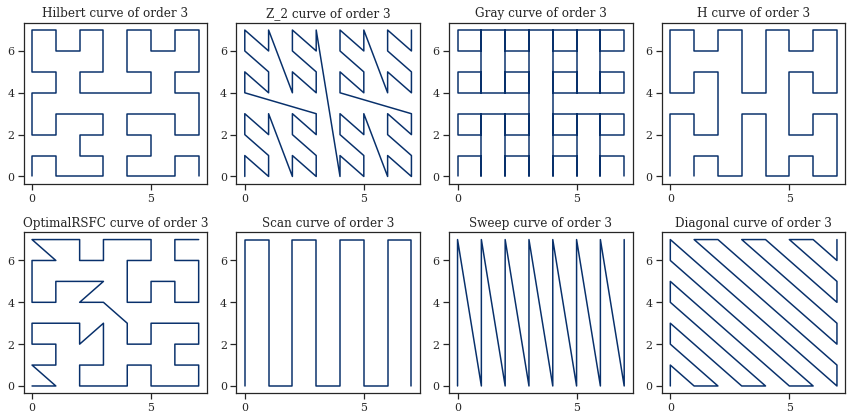

In [5]:
def plot_curve(name_curve,level=3,save=False,ax=None):
    curve =representation.choose_curve(name_curve,4**level,method="sfc")
    curve.plot(save=save,ax=ax,path=PATH_FIG)
    
with sns.plotting_context("notebook",font_scale=1):
    fig,ax=plt.subplots(2,4,figsize=(12,6))
    ax=ax.flatten()
    for i, name_curve in enumerate(["Hilbert","Z","Gray","H","OptimalRSFC","Scan","Sweep","Diagonal"]):
        plot_curve(name_curve,ax=ax[i],level=3)
    plt.tight_layout()


## Results

You will find below the plot of the *results* section.

### Res8 receptive field

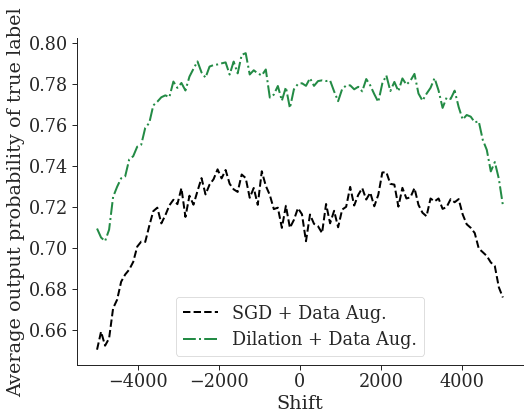

In [4]:
name_curve="Z"
assert os.path.exists("robustness")
# res8Z.csv and res8dilZ.csv
filenames=["robustness/res8{}.csv".format(name_curve),"robustness/res8dil{}.csv".format(name_curve)]
res = [pd.read_csv(file,dtype={'IsTop5': np.bool}) for file in filenames]
def avg_prob_shift(df, equal_weight_class=False):
    if equal_weight_class:
        # first take the mean per label per shift
        mean=pd.pivot_table(df, values='probs', index=['label'],
                    columns=['shifts'], aggfunc=np.mean)
        # take the mean over labels
        return mean.mean(axis=0)
    else:
        # take the mean over the whole dataframe.
        return df.groupby("shifts").probs.mean()

def plot_dilation_effect(save=False,figsize=(8,6),equal_weight_class=False):
    fig=plt.figure(figsize=figsize)
    legend=["SGD + Data Aug.","Dilation + Data Aug."]
    style=["--","-."]
    for i,df in enumerate(res):
        mean = avg_prob_shift(df,equal_weight_class)
        plt.plot(mean,label=legend[i],linewidth=2,linestyle=style[i])
    plt.xlabel("Shift")
    plt.ylabel("Average output probability of true label")
    plt.legend()
    sns.despine(fig)
    if save:
        plt.savefig(os.path.join(PATH_FIG,"res8dilation_effect.png"),bbox_inches='tight',dpi=150)
plot_dilation_effect(save=True,equal_weight_class=False)


### Model scaling:
Change the width of the network.

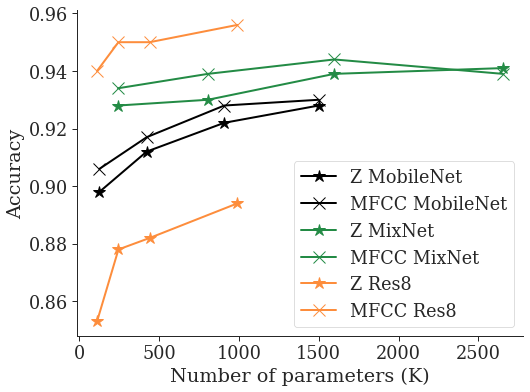

In [5]:
# test acc with data aug. (mobilenetv3)
params_sc=[126,422,908,1500]
Z_acc_sc=[0.898, 0.912,0.922,0.928]
mfcc_acc_sc=[0.906, 0.917,  0.928,   0.930]
df_sc={"params":params_sc,"Z_acc":Z_acc_sc,"mfcc_acc":mfcc_acc_sc,"model_name":"MobileNet"}

# test acc with data aug. (mixnet)
params_mixnet=[243,806,1597,2653]
Z_acc_mixnet=[0.928,0.930,0.939,0.941]
mfcc_acc_mixnet=[0.934,0.939,0.944,0.939]
df_mixnet={"params":params_mixnet,"Z_acc":Z_acc_mixnet,"mfcc_acc":mfcc_acc_mixnet,"model_name":"MixNet"}

# test acc with data aug. (res8)
params_res8=[111,245,441,990]
Z_acc_res8=[0.853,0.878,0.882,0.894]
mfcc_acc_res8=[0.940,0.950,0.950,0.956]
df_res8={"params":params_res8,"Z_acc":Z_acc_res8,"mfcc_acc":mfcc_acc_res8,"model_name":"Res8"}

def plot_width_scaling(dfs,save=False):
    fig=plt.figure(figsize=(8,6))
    # set palette 
    palette = itertools.cycle(sns.color_palette())
    for df in dfs:
        c = next(palette)
        plt.plot(df["params"],df["Z_acc"],label="Z "+df["model_name"],marker="*",color=c,linewidth=2,markersize=12)
        plt.plot(df["params"],df["mfcc_acc"],label="MFCC "+df["model_name"],marker="x",color=c,linewidth=2,markersize=12)
    plt.xlabel("Number of parameters (K)")
    plt.ylabel("Accuracy")
    plt.legend()
    sns.despine(fig)
    if save:
        plt.savefig(os.path.join(PATH_FIG,"width_mult_sc_data_aug.png"),dpi=150)
plot_width_scaling([df_sc,df_mixnet,df_res8],save=True)


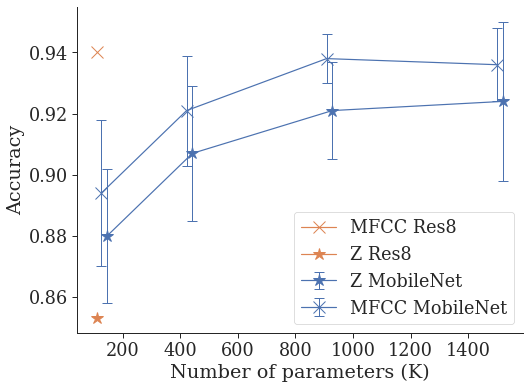

In [4]:
# number of parameters
params=np.array([126,422,908,1500])
# cross validation mean+std on speech commands with MobileNetV3
Z_acc_mean=[0.88,0.907,0.921,0.924]
mfcc_acc_mean=[0.894,0.921,0.938,0.936]
Z_err=np.array([0.011,0.011,0.008,0.013])
mfcc_err=np.array([0.012,0.009,0.004,0.006])
df_cross_val={"params":params,"Z_acc":Z_acc_mean,"mfcc_acc":mfcc_acc_mean,"Z_err":Z_err,"mfcc_err":mfcc_err}

def plot_width_scaling_cross_val(df,save=False):
    fig=plt.figure(figsize=(8,6))
    # set palette 
    palette = itertools.cycle(sns.color_palette())
    c=next(palette)
    # gaussian approx. (shift by 20 to distinguish the line on the plot)
    plt.errorbar(df["params"]+20,df["Z_acc"],yerr=2*df["Z_err"],label="Z MobileNet",marker="*",capsize=5,color=c,elinewidth=1,markersize=12)
    plt.errorbar(df["params"],df["mfcc_acc"],yerr=2*df["mfcc_err"],label="MFCC MobileNet",marker="x",capsize=5,color=c,elinewidth=1,markersize=12)
    c=next(palette)
    plt.plot(111,0.940,color=c,marker="x",label="MFCC Res8",linestyle=None,markersize=12)
    plt.plot(111,0.853,marker="*",color=c,label="Z Res8",linestyle=None,markersize=12)
    plt.xlabel("Number of parameters (K)")
    plt.ylabel("Accuracy")
    plt.legend()
    sns.despine(fig)
    if save:
        plt.savefig(os.path.join(PATH_FIG,"width_mult_sc_mixup_shift_CI.png"),dpi=150)
plot_width_scaling_cross_val(df_cross_val,save=True)